In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

df = pd.read_csv("../datasets/original_treated.csv")

X = df[["g1", "g2", "final_grade", "canceled_discipline", "skipped_discipline"]]
y = df["status"]

# 3. Dividir treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4. Treinar modelo
model = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    class_weight="balanced",
)
model.fit(X_train, y_train)

# 5. Prever
y_pred = model.predict(X_test)

# 6. Avaliar
print("Acurácia:", accuracy_score(y_test, y_pred))
print("\nRelatório de classificação:")
print(classification_report(y_test, y_pred))

# 7. Importância das variáveis
importances = pd.Series(model.feature_importances_, index=X.columns)
print("\nImportância das notas para prever aprovação:")
print(importances.sort_values(ascending=False))

Acurácia: 0.9998610918183081

Relatório de classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1748
           1       1.00      1.00      1.00      5451

    accuracy                           1.00      7199
   macro avg       1.00      1.00      1.00      7199
weighted avg       1.00      1.00      1.00      7199


Importância das notas para prever aprovação:
final_grade            0.504506
g2                     0.288652
g1                     0.171380
canceled_discipline    0.022801
skipped_discipline     0.012660
dtype: float64



--- Análise com SHAP ---

Gerando gráfico de resumo SHAP (multi-classe)...


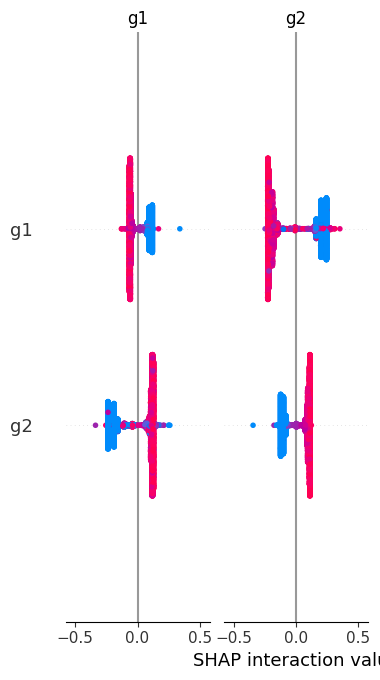


Classes do modelo: [np.int64(0), np.int64(1)]
Analisando as previsões para a classe '1' (índice: 1)

Analisando a previsão para um aluno específico com o Force Plot...


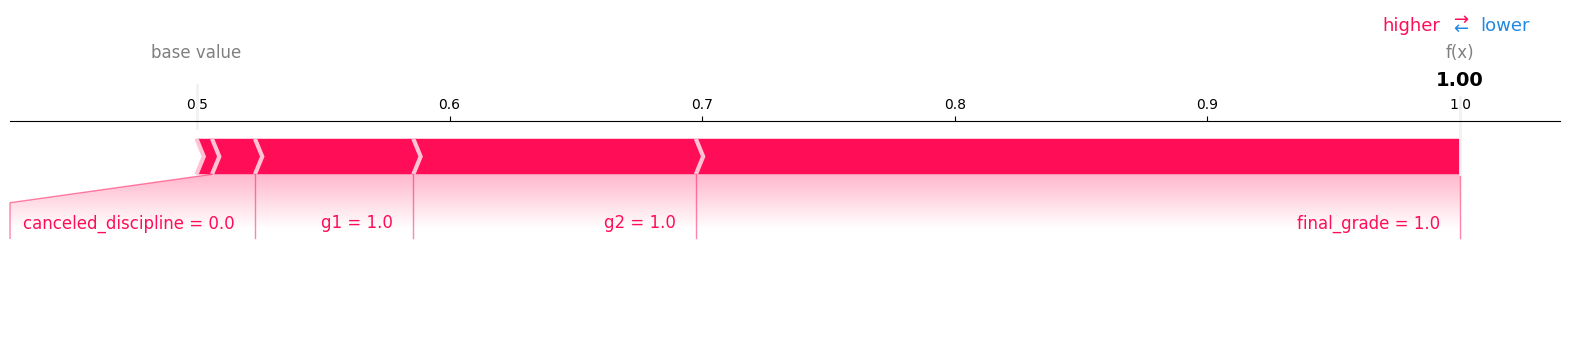


Gerando gráfico de resumo SHAP apenas para a classe '1'...


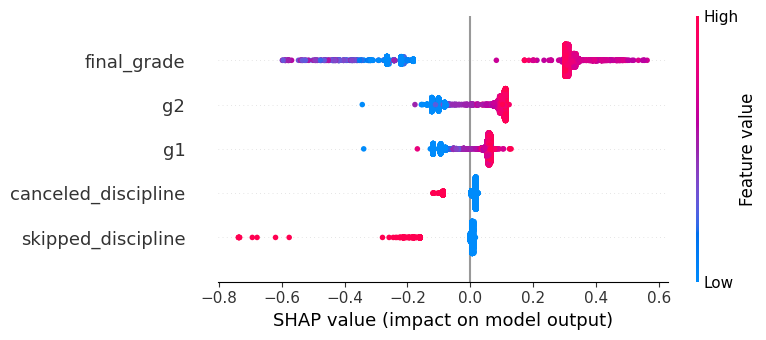

In [17]:
# ---------------------------------------------------------------------------------
# 8. VALIDAÇÃO E INTERPRETAÇÃO COM SHAP (VERSÃO CORRIGIDA E ROBUSTA)
# ---------------------------------------------------------------------------------
import shap

print("\n--- Análise com SHAP ---")

# Criar um objeto explainer para modelos de árvore
explainer = shap.TreeExplainer(model)

# Calcular os valores SHAP para o conjunto de teste.
# O resultado pode ser uma lista de arrays (um por classe) ou um único array 3D.
shap_values = explainer.shap_values(X_test)

# --- Gráfico de Resumo Geral (Recomendado) ---
# Passando o objeto shap_values completo, o SHAP gera um gráfico multi-classe
# que é mais informativo, mostrando o impacto das variáveis em cada classe.
print("\nGerando gráfico de resumo SHAP (multi-classe)...")
shap.summary_plot(shap_values, X_test, plot_type="dot", show=True)


# --- Análise Focada em Uma Única Classe e Uma Única Previsão ---

# Para analisar uma previsão específica (force_plot), precisamos focar em uma classe.
# 1. Identificar o nome das classes que o modelo aprendeu
class_names = model.classes_
print(f"\nClasses do modelo: {list(class_names)}")

# 2. Definir a classe de interesse e encontrar seu índice
# Vamos focar na explicação para a classe 'approved' (ou o nome da sua classe positiva)
target_class_name = 1

# Encontra o índice correspondente ao nome da classe. Use um try-except para segurança.
try:
    class_index = list(class_names).index(target_class_name)
    print(f"Analisando as previsões para a classe '{target_class_name}' (índice: {class_index})")
except ValueError:
    print(f"ERRO: A classe '{target_class_name}' não foi encontrada em model.classes_. Usando índice 0 por padrão.")
    class_index = 0
    
# 3. Preparar os dados para a classe única, tratando tanto o caso de lista quanto de array 3D
if isinstance(shap_values, list):
    # Se shap_values for uma lista, simplesmente pegamos o array do nosso índice
    shap_values_single_class = shap_values[class_index]
else:
    # Se for um array 3D, fatiamos para pegar a terceira dimensão correspondente à classe
    shap_values_single_class = shap_values[:, :, class_index]
    
# 4. Gerar o Gráfico de Forças (Force Plot) para uma previsão individual
# Analisando o primeiro aluno (índice 0) do conjunto de teste.
print("\nAnalisando a previsão para um aluno específico com o Force Plot...")

# Para notebooks (Jupyter, Colab), a linha abaixo melhora a renderização
shap.initjs()

student_id = 45

# O Force Plot mostra como cada variável "empurrou" a previsão para o resultado final
shap.force_plot(
    explainer.expected_value[class_index],
    shap_values_single_class[student_id,:], # SHAP values do primeiro aluno
    X_test.iloc[student_id,:],              # Valores das variáveis do primeiro aluno
    matplotlib=True,
    show=True,
)

# (Opcional) Gerar o summary plot para a classe única que selecionamos
print(f"\nGerando gráfico de resumo SHAP apenas para a classe '{target_class_name}'...")
shap.summary_plot(
    shap_values_single_class,
    X_test,
    plot_type="dot",
    show=True,
)